In [2]:
from sklearn.manifold import Isomap,SpectralEmbedding
import os
from pydicom import dcmread
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import imageio

In [ ]:
#2D model
#input data
data_path = "../data/SCD0000101/CINELAX_301"
all_times = []
all_slices = []
pixel_arrays = []
for dcm_file in os.listdir(data_path):
    dcm = dcmread(os.path.join(data_path, dcm_file))
    pixel_array = dcm.pixel_array
    pixel_array = (pixel_array - np.mean(pixel_array))/np.std(pixel_array)
    pixel_arrays.append(pixel_array)
    time = dcm.TriggerTime
    slice = dcm.SliceLocation
    all_slices.append(slice)
    all_times.append(time)
pixel_arrays = np.array(pixel_arrays)
all_times = np.array(all_times)
all_slices = np.array(all_slices)
indices = np.where(all_slices == np.median(all_slices))[0]
selected_times = all_times[indices]
selected_arrays = pixel_arrays[indices]
#calculate affinity matrix
sigma = 15
w = np.zeros((selected_arrays.shape[0], selected_arrays.shape[0]))
for i in range(selected_arrays.shape[0]):
    for j in range(selected_arrays.shape[0]):
        w[i, j] = np.exp(-np.sum((selected_arrays[i] - selected_arrays[j])**2)/(sigma**2))
#calculate degree matrix
d = np.diag(np.sum(w, axis=1))
#calculate laplacian matrix
l = d - w
#apply isomap and laplacian eigenmaps
isomap = Isomap(n_components=1,n_neighbors=10)
laplacian_eigenmaps = SpectralEmbedding(n_components=1,affinity='precomputed')
laplacian_embedding = laplacian_eigenmaps.fit_transform(w)
embedding = isomap.fit_transform(w)

Correlation Laplacian Eigenmaps:  -0.5716992093523644


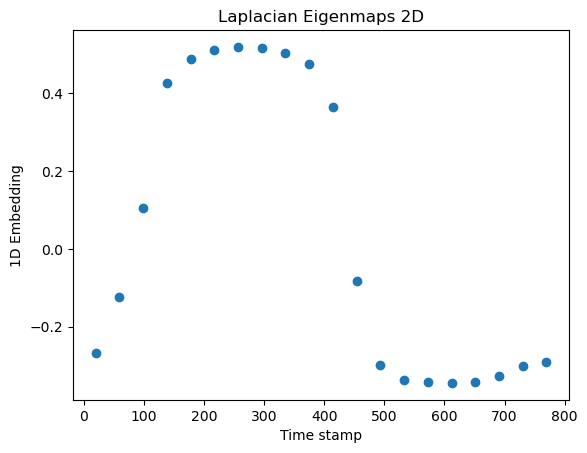

Correlation Isomap:  -0.5326139014362482


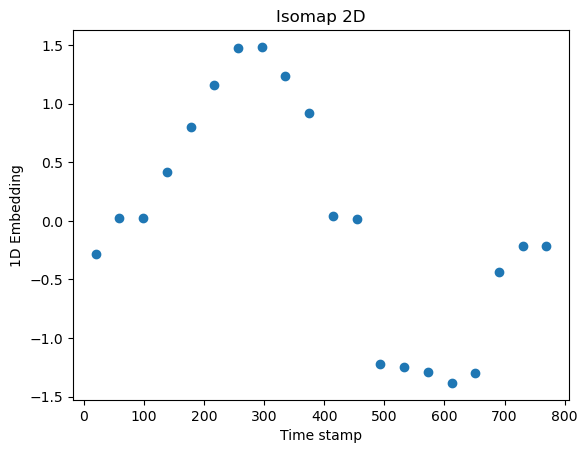

In [161]:
corr_laplacian = np.corrcoef(laplacian_embedding.ravel(), selected_times)[0, 1]
corr_isomap = np.corrcoef(embedding.ravel(), selected_times)[0, 1]
print("Correlation Laplacian Eigenmaps: ", corr_laplacian)
plt.scatter(selected_times, laplacian_embedding.ravel())
plt.title("Laplacian Eigenmaps 2D")
plt.ylabel("1D Embedding")
plt.xlabel("Time stamp")
plt.savefig("laplacian_embedding_2d.png")
plt.show()
print("Correlation Isomap: ", corr_isomap)
plt.scatter(selected_times, embedding.ravel())
plt.title("Isomap 2D")
plt.ylabel("1D Embedding")
plt.xlabel("Time stamp")
plt.savefig("isomap_2d.png")
plt.show()

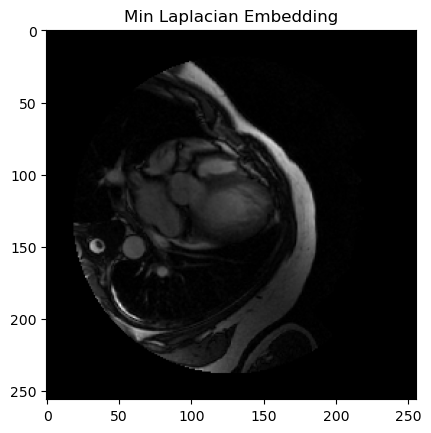

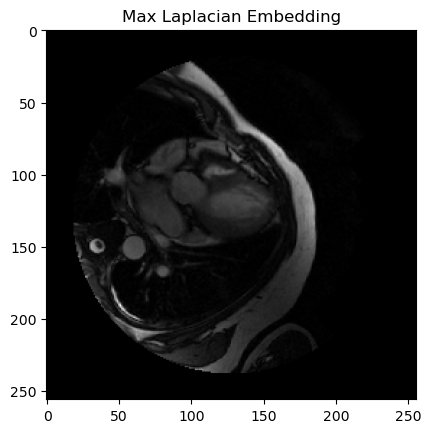

In [163]:
#plot min and max images from laplacian embedding
min_idx = np.argmin(laplacian_embedding)
max_idx = np.argmax(laplacian_embedding)
min_img = selected_arrays[min_idx]
max_img = selected_arrays[max_idx]
plt.imshow(min_img, cmap='gray')
plt.title("Min Laplacian Embedding")
plt.savefig("min_laplacian_embedding.png")
plt.show()
plt.imshow(max_img, cmap='gray')
plt.title("Max Laplacian Embedding")
plt.savefig("max_laplacian_embedding.png")
plt.show()

In [ ]:
#3D model
#input data
data_path = "../data/SCD0000101/CINELAX_301"
all_times = dict()
all_slices = []
pixel_arrays = dict()
for dcm_file in os.listdir(data_path):
    dcm = dcmread(os.path.join(data_path, dcm_file))
    pixel_array = dcm.pixel_array
    pixel_array = (pixel_array - np.mean(pixel_array))/np.std(pixel_array)
    time = dcm.TriggerTime
    slice = dcm.SliceLocation
    if slice not in pixel_arrays.keys():
        pixel_arrays[slice] = []
        all_times[slice] = []
    pixel_arrays[slice].append(pixel_array)
    all_times[slice].append(time)
for slice in pixel_arrays.keys():
    pixel_arrays[slice] = np.array(pixel_arrays[slice])
    all_times[slice] = np.array(all_times[slice])
    indices = np.argsort(all_times[slice])
    pixel_arrays[slice] = pixel_arrays[slice][indices]
    all_times[slice] = all_times[slice][indices]
    num_times = len((all_times[slice]))

volume_array = []
for i in range(num_times):
    curr_slice = []
    for slice in pixel_arrays.keys():
        curr_slice.append(pixel_arrays[slice][i])
    curr_slice = np.array(curr_slice)
    volume_array.append(curr_slice)
volume_array = np.array(volume_array)

#calculate affinity matrix
sigma = 15
w = np.zeros((volume_array.shape[0], volume_array.shape[0]))
for i in range(volume_array.shape[0]):
    for j in range(volume_array.shape[0]):
        w[i, j] = np.exp(-np.sum((volume_array[i] - volume_array[j])**2)/(sigma**2))
#calculate degree matrix
d = np.diag(np.sum(w, axis=1))
#calculate laplacian matrix
l = d - w
#apply isomap and laplacian eigenmaps
isomap = Isomap(n_components=1,n_neighbors=10)
laplacian_eigenmaps = SpectralEmbedding(n_components=1,affinity='precomputed')
laplacian_embedding = laplacian_eigenmaps.fit_transform(w)
embedding = isomap.fit_transform(w)

Correlation Laplacian Eigenmaps:  -0.5287334909238101


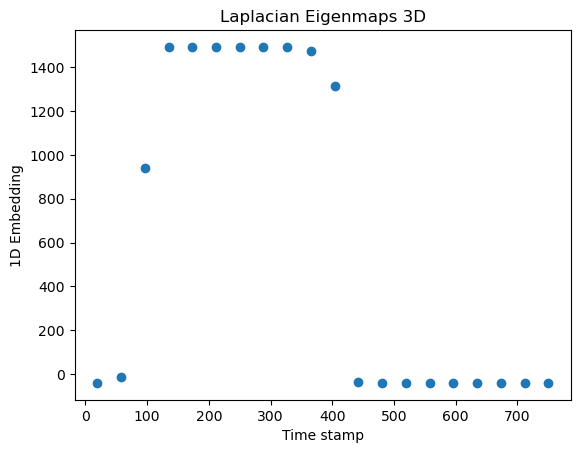

Correlation Isomap:  0.5391892395644812


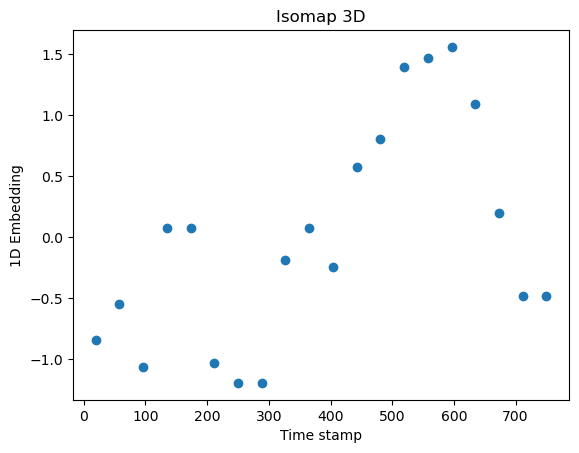

In [152]:
for slice in all_times.keys():
    times = all_times[slice]
    break
corr_laplacian = np.corrcoef(laplacian_embedding.ravel(), times)[0, 1]
corr_isomap = np.corrcoef(embedding.ravel(), times)[0, 1]
print("Correlation Laplacian Eigenmaps: ", corr_laplacian)
plt.scatter(times, laplacian_embedding.ravel())
plt.title("Laplacian Eigenmaps 3D")
plt.ylabel("1D Embedding")
plt.xlabel("Time stamp")
plt.show()
plt.savefig("laplacian_embedding_3d.png")
print("Correlation Isomap: ", corr_isomap)
plt.scatter(times, embedding.ravel())
plt.title("Isomap 3D")
plt.ylabel("1D Embedding")
plt.xlabel("Time stamp")
plt.savefig("isomap_3d.png")
plt.show()

In [4]:
# create gif of cardiac MRI
#input data
data_path = "../data/SCD0000101/CINELAX_301"
all_times = []
all_slices = []
pixel_arrays = []
for dcm_file in os.listdir(data_path):
    dcm = dcmread(os.path.join(data_path, dcm_file))
    pixel_array = dcm.pixel_array
    pixel_arrays.append(pixel_array)
    time = dcm.TriggerTime
    slice = dcm.SliceLocation
    all_slices.append(slice)
    all_times.append(time)
pixel_arrays = np.array(pixel_arrays)
all_times = np.array(all_times)
all_slices = np.array(all_slices)
indices = np.where(all_slices == np.median(all_slices))[0]
selected_times = all_times[indices]
selected_arrays = pixel_arrays[indices]
indices = np.argsort(selected_times)
selected_times = selected_times[indices]
selected_arrays = selected_arrays[indices]

# selected_arrays_rgb = np.stack([selected_arrays]*3, axis=-1)
for i in range(selected_arrays.shape[0]):
    output_path = f"example_cardiac_mri_{i}.png"
    # imageio.mimsave(output_path, selected_arrays[i], duration=0.1)
    plt.imshow(selected_arrays[i], cmap='gray')
    plt.axis('off')
    plt.savefig(output_path)
    print("PNG saved to ", output_path)
    plt.close()

PNG saved to  example_cardiac_mri_0.png
PNG saved to  example_cardiac_mri_1.png
PNG saved to  example_cardiac_mri_2.png
PNG saved to  example_cardiac_mri_3.png
PNG saved to  example_cardiac_mri_4.png
PNG saved to  example_cardiac_mri_5.png
PNG saved to  example_cardiac_mri_6.png
PNG saved to  example_cardiac_mri_7.png
PNG saved to  example_cardiac_mri_8.png
PNG saved to  example_cardiac_mri_9.png
PNG saved to  example_cardiac_mri_10.png
PNG saved to  example_cardiac_mri_11.png
PNG saved to  example_cardiac_mri_12.png
PNG saved to  example_cardiac_mri_13.png
PNG saved to  example_cardiac_mri_14.png
PNG saved to  example_cardiac_mri_15.png
PNG saved to  example_cardiac_mri_16.png
PNG saved to  example_cardiac_mri_17.png
PNG saved to  example_cardiac_mri_18.png
PNG saved to  example_cardiac_mri_19.png
